<a href="https://colab.research.google.com/github/aparnashenoy/ml/blob/master/2_cost_sensitive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
df= pd.read_csv("/gdrive/My Drive/traindata.csv")

In [4]:
df.head()

,Unnamed: 0,X,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1,1,84.0,98.0,37.06,118.5,77.00,58.5,18.0,24.0,0.50,7.39,40.0,97.0,57.0,18.0,78.0,8.3,106.0,0.9,1.4,124.0,1.8,2.0,3.4,4.1,0.9,4.3,30.2,10.4,32.4,10.8,250.0,181.0,83.14,0,1,0,-0.03,1,0
1,2,2,97.0,95.0,37.06,98.0,75.33,58.5,19.0,24.0,0.50,7.39,40.0,97.0,57.0,18.0,78.0,8.3,106.0,0.9,1.4,124.0,1.8,2.0,3.4,4.1,0.9,4.3,30.2,10.4,32.4,10.8,250.0,181.0,83.14,0,1,0,-0.03,2,0
2,3,3,89.0,99.0,37.06,122.0,86.00,58.5,22.0,24.0,0.50,7.39,40.0,97.0,57.0,18.0,78.0,8.3,106.0,0.9,1.4,124.0,1.8,2.0,3.4,4.1,0.9,4.3,30.2,10.4,32.4,10.8,250.0,181.0,83.14,0,1,0,-0.03,3,0
3,4,4,90.0,95.0,37.06,118.5,77.00,58.5,30.0,24.0,0.50,7.36,100.0,97.0,57.0,18.0,78.0,8.3,106.0,0.9,1.4,124.0,1.8,2.0,3.4,4.1,0.9,4.3,30.2,10.4,32.4,10.8,250.0,181.0,83.14,0,1,0,-0.03,4,0
4,5,5,103.0,88.5,37.06,122.0,91.33,58.5,24.5,24.0,0.28,7.39,40.0,97.0,57.0,18.0,78.0,8.3,106.0,0.9,1.4,124.0,1.8,2.0,3.4,4.1,0.9,4.3,30.2,10.4,32.4,10.8,250.0,181.0,83.14,0,1,0,-0.03,5,0


In [5]:
df=df.drop(['Unnamed: 0','X'],axis=1)

In [6]:
import numpy as np
X=np.array(df.drop(['SepsisLabel'],1))
y=np.array(df['SepsisLabel'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (790215, 38)
Shape of y: (790215,)


In [7]:
counter = Counter(y)
print(counter)

Counter({0: 773079, 1: 17136})


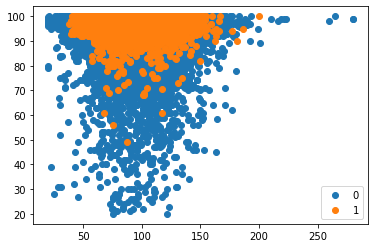

In [8]:
for label, _ in counter.items():
  row_ix =where(y == label)[0]
  pyplot.scatter(X[row_ix,0], X[row_ix,1], label=str(label))
pyplot.legend()
pyplot.show()

In [9]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

In [10]:
md_imp = ExtraTreesClassifier()
X=np.array(df.drop(['SepsisLabel'],1))
y=np.array(df['SepsisLabel'])
md_imp.fit(X,y)
print(md_imp.feature_importances_)

[0.08105576 0.06322402 0.04910294 0.07566713 0.0769907  0.06455276
 0.07158829 0.00496229 0.02283664 0.01679959 0.0136159  0.00731396
 0.00259131 0.00492022 0.00275761 0.00355696 0.00503064 0.00401169
 0.00067854 0.01068963 0.01054833 0.00533264 0.00354275 0.00842263
 0.0022249  0.00031714 0.01027099 0.00651572 0.00649737 0.00541516
 0.00256423 0.00486309 0.11341911 0.00486951 0.00111699 0.00130693
 0.09914706 0.13167886]


Text(0.5, 0, 'Relative Importance')

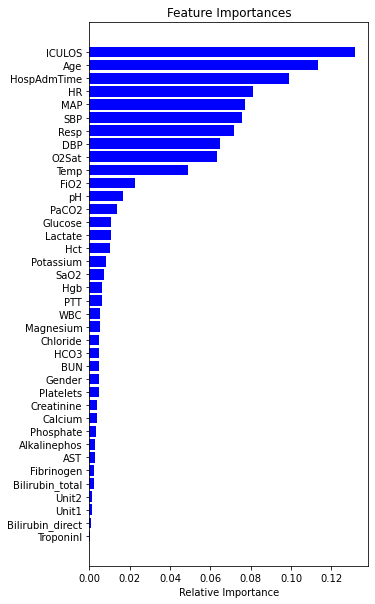

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
features=df.columns
importances = md_imp.feature_importances_
indices = np.argsort(importances)
pyplot.figure(1)
pyplot.title('Feature Importances')
pyplot.barh(range(len(indices)), importances[indices], color='b', align='center')
pyplot.yticks(range(len(indices)), features[indices])
pyplot.xlabel('Relative Importance')

In [12]:
model = LogisticRegression(solver='lbfgs')

In [13]:
cv = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state=1)

In [14]:
scores = cross_val_score(model, X,y, scoring='roc_auc', cv = cv, n_jobs=-1)

In [15]:
print('Mean ROC AUC: %3f' %mean(scores))

Mean ROC AUC: 0.709652


In [16]:
weights = {0:0.01, 1:1.0}
model_1 = LogisticRegression(solver='lbfgs', class_weight= weights)
cv_1 = RepeatedStratifiedKFold(n_splits= 10, n_repeats= 3, random_state=1)
scores_1 = cross_val_score(model_1, X,y, scoring='roc_auc', cv = cv_1, n_jobs=-1)
print('Mean ROC AUC: %3f' %mean(scores_1))

Mean ROC AUC: 0.715475


In [17]:
from sklearn.utils.class_weight import compute_class_weight
# calculate class weighting
weighting = compute_class_weight('balanced', [0,1], y)
print(weighting)

[ 0.51108296 23.05716036]


In [18]:
model_2 = LogisticRegression(solver='lbfgs', class_weight='balanced')
cv_2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_2=cross_val_score(model_2, X,y,scoring = 'roc_auc', cv = cv_2,n_jobs=-1)
print('Mean ROC AUC: %.3f' %mean(scores_2))

Mean ROC AUC: 0.715


In [19]:
from sklearn.model_selection import GridSearchCV
#define model
model_3 = LogisticRegression(solver = 'lbfgs')
#define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, {0:0.5,1:23}]
param_grid = dict(class_weight = balance)
#define evaluation procedure
cv_3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#define grid search
grid = GridSearchCV(estimator= model_3, param_grid=param_grid, n_jobs=-1, cv=cv_3,
                    scoring = 'roc_auc')
#execute the grid search
grid_result = grid.fit(X,y)
#report all configuration
print('Best: %f using %s' %(grid_result.best_score_, grid_result.best_params_))
#report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.715769 using {'class_weight': {0: 1, 1: 100}}
0.705812 (0.005967) with: {'class_weight': {0: 100, 1: 1}}
0.707570 (0.005800) with: {'class_weight': {0: 10, 1: 1}}
0.709652 (0.005853) with: {'class_weight': {0: 1, 1: 1}}
0.712096 (0.005818) with: {'class_weight': {0: 1, 1: 10}}
0.715769 (0.006010) with: {'class_weight': {0: 1, 1: 100}}
0.714480 (0.006199) with: {'class_weight': {0: 0.5, 1: 23}}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
